# Project Overview: Semi-Supervised Learning with STAC for Dental X-Ray Analysis
This work aims to develop a means of detecting Dental Pathologies (Caries, Fractures, & Impacted teeth in X-ray images) using an SSL approach: i.e., the use of a small amount of labelled (annotated) training data in conjunction with thousands of unlabeled (raw) training images to train more accurate models for Dental Pathologies.

## What this notebook does
1. Data Preparation - Dataset was split into labeled training, unlabeled training, validation, and test sets.

2. Enhancing X-ray Image - CLAHE (Contrast Limited Adaptive Histogram Equalization) was used for enhancing the visibility of dental features in x-rays.

3. Class Balancing - Oversampling was performed for minority classes to improve the ability of the model to recognise all pathologies, and thus address imbalance in the dataset.

## Dataset
1. Original Root Directory: /kaggle/input/dental-x-ray/Multi-Source Dental X-Ray Dataset Using Image-to-I/Teeth Xray Image Dataset/Teeth Xray Image Dataset/Teeth View Xray Image Dataset/Dental Xray (Ojected Detection)

2. Processed YOLO Structure: All training data is enhanced using CLAHE and stored under: /kaggle/working/ssl_dataset_enhanced/

* train/labeled/: 20% of the training data with manual annotations.

* train/unlabeled/: 80% of the training data (raw images) for SSL.

* val/: Validation set for monitoring training.

* test/: Final evaluation set for testing the Student model.

## Reading the Results
To interpret the success of this project, monitor the following metrics:

1. Detector Metrics (Primary):
* mAP@0.50: Indicates the model’s ability to find and correctly identify teeth/pathologies.

* mAP@0.50: 0.95: Measures the precision of the bounding box placement.

2. Training Logs:
* Box Loss (↓): A decreasing curve shows the model is getting better at locating objects.

* Class Loss (↓): Indicates the model is becoming more accurate at distinguishing between "Caries" vs. "Healthy".

3. Sanity Checks:
t-SNE / PCA: Visualizing the feature clusters can confirm that "Impacted" teeth features are distinct from "Healthy" teeth features in the model's latent space.

### Image Preprocessing

In [1]:
# --- INSTALL DEPENDENCIES ---
!pip install -U ultralytics --no-deps

import os
# --- CRITICAL: Memory Management ---
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import shutil
import random
import cv2
import yaml
import torch
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")

# --- CONFIGURATION ---
# 1. INPUT PATH (EXACTLY AS PROVIDED)
input_root = Path("/kaggle/input/dental-x-ray/Multi-Source Dental X-Ray Dataset Using Image-to-I/Teeth Xray Image Dataset/Teeth Xray Image Dataset/Teeth View Xray Image Dataset/Dental Xray (Ojected Detection)")
input_images = input_root / "images"
input_labels = input_root / "labels"

# 2. OUTPUT PATHS
base_dir = Path("/kaggle/working/ssl_dataset_raw")
split_dirs = {
    "train_labeled": base_dir / "train/labeled",
    "train_raw": base_dir / "train/raw",
    "val": base_dir / "val",
    "test": base_dir / "test"
}

# --- VALIDATION CHECK ---
print(f"Checking input directory: {input_root}")
if not input_images.exists():
    print(f"❌ CRITICAL ERROR: Input image directory NOT found at:\n{input_images}")
    print("Please verify the dataset path in the 'input_root' variable above.")
    raise FileNotFoundError("Input dataset not found")

# Gather Files
all_jpgs = list(input_images.glob("*.jpg"))
valid_pairs = []
for img in all_jpgs:
    lbl = input_labels / f"{img.stem}.txt"
    if lbl.exists():
        valid_pairs.append((img, lbl))

print(f"✅ Found {len(valid_pairs)} valid image-label pairs.")
if len(valid_pairs) == 0:
    raise ValueError("Found 0 pairs! Check if labels folder matches image names.")

# --- CLEAN & RECREATE FOLDERS ---
if base_dir.exists(): shutil.rmtree(base_dir)
for p in split_dirs.values():
    (p / "images").mkdir(parents=True, exist_ok=True)
    if p != split_dirs["train_raw"]:
        (p / "labels").mkdir(parents=True, exist_ok=True)

# --- SPLITTING ---
# 1. Train (80%) vs Temp (20%)
train_pairs, temp_pairs = train_test_split(valid_pairs, test_size=0.2, random_state=42)
# 2. Val (10%) vs Test (10%)
val_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.5, random_state=42)
# 3. Labeled Train (20%) vs Raw Train (80%)
labeled_train, raw_train = train_test_split(train_pairs, test_size=0.8, random_state=42)

print(f"Splitting Data:\n - Labeled Train: {len(labeled_train)}\n - Raw Train:     {len(raw_train)}\n - Validation:    {len(val_pairs)}\n - Test:          {len(test_pairs)}")

# Copy Files
def copy_files(pairs, dest, is_raw=False):
    for img_src, lbl_src in tqdm(pairs, desc=f"Copying to {dest.name}"):
        shutil.copy(img_src, dest / "images" / img_src.name)
        if not is_raw:
            shutil.copy(lbl_src, dest / "labels" / lbl_src.name)

copy_files(labeled_train, split_dirs["train_labeled"])
copy_files(raw_train, split_dirs["train_raw"], is_raw=True)
copy_files(val_pairs, split_dirs["val"])
copy_files(test_pairs, split_dirs["test"])

print("\n✅ Cell 1 Complete: Data Split Successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.7 MB/s eta 0:00:00
Checking input directory: /kaggle/input/dental-x-ray/Multi-Source Dental X-Ray Dataset Using Image-to-I/Teeth Xray Image Dataset/Teeth Xray Image Dataset/Teeth View Xray Image Dataset/Dental Xray (Ojected Detection)
✅ Found 1649 valid image-label pairs.
Splitting Data:
 - Labeled Train: 263
 - Raw Train:     1056
 - Validation:    165
 - Test:          165


Copying to labeled:   0%|          | 0/263 [00:00<?, ?it/s]

Copying to raw:   0%|          | 0/1056 [00:00<?, ?it/s]

Copying to val:   0%|          | 0/165 [00:00<?, ?it/s]

Copying to test:   0%|          | 0/165 [00:00<?, ?it/s]


✅ Cell 1 Complete: Data Split Successfully.


### Data Quality Verification & Visualization

In [2]:
# --- CONFIG ---
raw_root = Path("/kaggle/working/ssl_dataset_raw")
enhanced_root = Path("/kaggle/working/ssl_dataset_enhanced")
class_names = ["BDC-BDR", "Caries", "Fractured", "Healthy", "Impacted", "Inflection"]

print("--- Step 1: Applying CLAHE Enhancement ---")

def apply_clahe(img_path, save_path):
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None: return
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = cv2.cvtColor(clahe.apply(img), cv2.COLOR_GRAY2BGR)
    cv2.imwrite(str(save_path), enhanced)

if enhanced_root.exists(): shutil.rmtree(enhanced_root)

# Enhance all folders
for split in ["train/labeled", "train/raw", "val", "test"]:
    src = raw_root / split
    dst = enhanced_root / split
    (dst / "images").mkdir(parents=True, exist_ok=True)
    if (src / "labels").exists():
        (dst / "labels").mkdir(parents=True, exist_ok=True)
        for f in (src / "labels").glob("*.txt"):
            shutil.copy(f, dst / "labels" / f.name)
            
    images = list((src / "images").glob("*.jpg"))
    for img in tqdm(images, desc=f"Enhancing {split}"):
        apply_clahe(img, dst / "images" / img.name)

# --- BALANCING ---
print("\n--- Step 2: Balancing Classes (Labeled Train) ---")
lbl_dir = enhanced_root / "train/labeled/labels"
img_dir = enhanced_root / "train/labeled/images"

# Count Classes
class_counts = Counter()
files_with_class = {k: [] for k in range(6)}

for f in lbl_dir.glob("*.txt"):
    with open(f) as txt:
        classes = set()
        for line in txt:
            c = int(line.split()[0])
            class_counts[c] += 1
            classes.add(c)
        for c in classes:
            files_with_class[c].append(f)

# Visualize Imbalance
print("Class Counts BEFORE Balancing:")
for c, count in sorted(class_counts.items()):
    print(f"  {class_names[c]}: {count}")

# Oversample to 50% of majority
target = int(max(class_counts.values()) * 0.5)
added = 0

for c, count in class_counts.items():
    if count < target:
        needed = target - count
        candidates = files_with_class[c]
        if not candidates: continue
        
        for _ in range(needed):
            src_lbl = random.choice(candidates)
            src_img = img_dir / f"{src_lbl.stem}.jpg"
            new_name = f"{src_img.stem}_bal_{added}"
            
            shutil.copy(src_img, img_dir / f"{new_name}.jpg")
            shutil.copy(src_lbl, lbl_dir / f"{new_name}.txt")
            added += 1

print(f"\n✅ Cell 2 Complete: Enhanced & Balanced (Added {added} images).")

--- Step 1: Applying CLAHE Enhancement ---


Enhancing train/labeled:   0%|          | 0/263 [00:00<?, ?it/s]

Enhancing train/raw:   0%|          | 0/1056 [00:00<?, ?it/s]

Enhancing val:   0%|          | 0/165 [00:00<?, ?it/s]

Enhancing test:   0%|          | 0/165 [00:00<?, ?it/s]


--- Step 2: Balancing Classes (Labeled Train) ---
Class Counts BEFORE Balancing:
  BDC-BDR: 689
  Caries: 664
  Fractured: 350
  Healthy: 299
  Impacted: 419
  Inflection: 547

✅ Cell 2 Complete: Enhanced & Balanced (Added 45 images).


### Training the Teacher Model

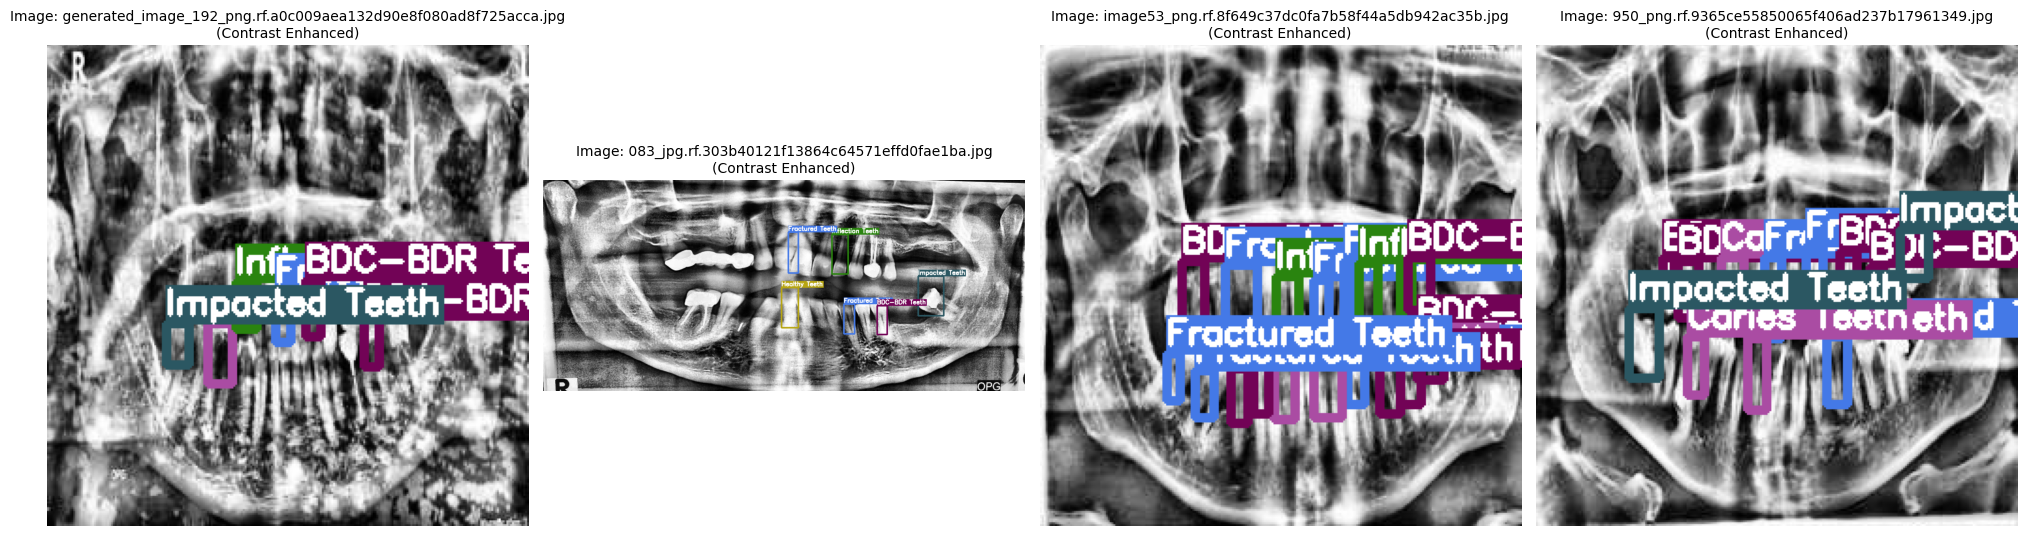

In [3]:
import cv2
import random
import matplotlib.pyplot as plt
from pathlib import Path

# --- CONFIGURATION ---
# We look at the 'enhanced' dataset since that is what the model trains on
dataset_path = Path("/kaggle/working/ssl_dataset_enhanced/train/labeled")
image_dir = dataset_path / "images"
label_dir = dataset_path / "labels"

class_names = [
    "BDC-BDR Teeth",   # 0
    "Caries Teeth",    # 1
    "Fractured Teeth", # 2
    "Healthy Teeth",   # 3
    "Impacted Teeth",  # 4
    "Inflection Teeth" # 5
]

# Generate random colors for each class
class_colors = {}
for i in range(len(class_names)):
    class_colors[i] = (random.randint(0, 200), random.randint(0, 200), random.randint(0, 255))

def visualize_dataset(num_samples=3):
    # 1. Gather Images
    if not image_dir.exists():
        print(f"❌ Error: Directory not found: {image_dir}")
        print("Please run the 'Enhancement & Balancing' cell first.")
        return

    all_images = list(image_dir.glob("*.jpg"))
    if not all_images:
        print("❌ Error: No images found in the directory.")
        return

    # 2. Pick Random Samples
    samples = random.sample(all_images, min(len(all_images), num_samples))
    
    plt.figure(figsize=(20, 12))
    
    for i, img_path in enumerate(samples):
        # Read Image
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        
        # Read Label
        label_path = label_dir / f"{img_path.stem}.txt"
        
        if label_path.exists():
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) < 5: continue
                    
                    cls_id = int(parts[0])
                    x_c, y_c, bw, bh = map(float, parts[1:])
                    
                    # Convert YOLO format (norm) to Pixel format
                    x1 = int((x_c - bw / 2) * w)
                    y1 = int((y_c - bh / 2) * h)
                    x2 = int((x_c + bw / 2) * w)
                    y2 = int((y_c + bh / 2) * h)
                    
                    # Draw Box
                    color = class_colors.get(cls_id, (255, 0, 0))
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)
                    
                    # Draw Text Background & Label
                    label_text = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
                    (tw, th), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                    cv2.rectangle(img, (x1, y1 - 20), (x1 + tw, y1), color, -1)
                    cv2.putText(img, label_text, (x1, y1 - 5), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        else:
            print(f"Warning: No label file for {img_path.name}")

        # Plot
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Image: {img_path.name}\n(Contrast Enhanced)", fontsize=10)

    plt.tight_layout()
    plt.show()

# --- RUN VISUALIZATION ---
visualize_dataset(num_samples=4)

### Teacher Performance Analysis

In [4]:
from ultralytics import YOLO

# --- CONFIG ---
work_dir = Path("/kaggle/working/stac_pipeline")
teacher_project = work_dir / "teacher_runs"
base_path = enhanced_root # Use ENHANCED data

# YAML Creation
teacher_yaml = work_dir / "teacher.yaml"
config = {
    "path": str(base_path.resolve()),
    "train": "train/labeled/images",
    "val": "val/images",
    "names": {i: n for i, n in enumerate(class_names)},
    "nc": 6
}
teacher_yaml.parent.mkdir(parents=True, exist_ok=True)
teacher_yaml.write_text(yaml.dump(config, sort_keys=False))

# TRAIN teacher
print("--- Training Teacher (YOLO11s) ---")
teacher = YOLO("yolo11s.pt") 

teacher.train(
    data=str(teacher_yaml),
    epochs=50,
    patience=10,
    imgsz=1024,      # High Res
    batch=4,         # Low batch
    
    # MEDICAL SETTINGS
    mosaic=0.0,      # Disable Mosaic
    mixup=0.0,       # Disable Mixup
    hsv_h=0.01,      # Min color shift
    hsv_s=0.0,       # Grayscale
    box=10.0,        # High Box Gain
    
    project=str(teacher_project),
    name="teacher_medical",
    device=0,
    verbose=True
)

print("\n✅ Cell 4: Teacher Trained.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
--- Training Teacher (YOLO11s) ---
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=10.0, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/stac_pipeline/teacher.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01, hsv_

### Reload Best Model


In [5]:
# Reload Best Model
best_weights = teacher_project / "teacher_medical" / "weights" / "best.pt"
if not best_weights.exists():
    raise FileNotFoundError("Teacher training failed. No weights found.")

model = YOLO(str(best_weights))
metrics = model.val(data=str(teacher_yaml), split='val', imgsz=1024, device=0)

print(f"\nTeacher mAP@50: {metrics.box.map50:.4f}")
if metrics.box.map50 < 0.2:
    print("⚠️ WARNING: Teacher is weak. Proceeding, but results may be poor.")
else:
    print("✅ Teacher is healthy.")

Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 100 layers, 9,415,122 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 949.7±160.9 MB/s, size: 69.0 KB)
val: Scanning /kaggle/working/ssl_dataset_enhanced/val/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 165/165 292.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 1.9it/s 5.7s
                   all        165       1862      0.133      0.232      0.122     0.0338
         BDC-BDR Teeth        140        422      0.149      0.363      0.123     0.0341
          Caries Teeth        148        433      0.105      0.125       0.05     0.0135
       Fractured Teeth         94        209          0          0     0.0335    0.00971
         Healthy Teeth        102        185      0.177      0.173      0.103     0.0322
        Impacted Teeth      

### Creating the Student Dataset

In [6]:
# --- CONFIG ---
pseudo_dir = work_dir / "pseudo_labels/labels"
if pseudo_dir.exists(): shutil.rmtree(pseudo_dir.parent)
pseudo_dir.mkdir(parents=True, exist_ok=True)

# Clean Memory
del model
gc.collect()
torch.cuda.empty_cache()

# Load Model
model = YOLO(str(best_weights))

# Low Thresholds
conf_map = {0: 0.15, 1: 0.10, 2: 0.15, 3: 0.25, 4: 0.20, 5: 0.20}

raw_images = list((base_path / "train/raw/images").glob("*.jpg"))
print(f"Generating labels for {len(raw_images)} images...")

total_boxes = 0
count = 0

for img_path in raw_images:
    try:
        results = model.predict(
            source=str(img_path),
            augment=True,    # TTA Enabled
            conf=0.05, 
            iou=0.6,
            imgsz=1024,
            save=False,
            verbose=False,
            device=0
        )
        
        valid_boxes = []
        for box in results[0].boxes:
            c = int(box.cls)
            p = float(box.conf)
            if p >= conf_map.get(c, 0.2):
                x, y, w, h = box.xywhn[0].tolist()
                valid_boxes.append(f"{c} {x:.6f} {y:.6f} {w:.6f} {h:.6f}")
        
        with open(pseudo_dir / f"{img_path.stem}.txt", "w") as f:
            if valid_boxes:
                f.write("\n".join(valid_boxes))
                total_boxes += len(valid_boxes)
                
    except Exception: pass
    
    count += 1
    if count % 100 == 0:
        print(f"Processed {count} | Boxes: {total_boxes}...", end="\r")

print(f"\n✅ Cell 6 Complete. Total Pseudo-Boxes: {total_boxes}")

Generating labels for 1056 images...
Processed 1000 | Boxes: 4822...
✅ Cell 6 Complete. Total Pseudo-Boxes: 5090


### Student Model Training

In [7]:
# --- MERGE DATA ---
student_data = work_dir / "student_dataset"
if student_data.exists(): shutil.rmtree(student_data)
(student_data / "images").mkdir(parents=True)
(student_data / "labels").mkdir(parents=True)

# Copy Labeled
for f in (base_path / "train/labeled/images").glob("*.jpg"): 
    shutil.copy(f, student_data / "images" / f.name)
for f in (base_path / "train/labeled/labels").glob("*.txt"): 
    shutil.copy(f, student_data / "labels" / f.name)

# Copy Pseudo
for f in (base_path / "train/raw/images").glob("*.jpg"): 
    shutil.copy(f, student_data / "images" / f.name)
for f in pseudo_dir.glob("*.txt"): 
    shutil.copy(f, student_data / "labels" / f.name)

# Student YAML
student_yaml = work_dir / "student.yaml"
cfg = config.copy()
cfg['train'] = str((student_data / "images").resolve())
student_yaml.write_text(yaml.dump(cfg, sort_keys=False))

# TRAIN
print("--- Training Student (YOLO11s) ---")
student = YOLO("yolo11s.pt")

student.train(
    data=str(student_yaml),
    epochs=60,
    patience=15,
    imgsz=1024,
    batch=4,
    
    # STUDENT AUGMENTATION
    mosaic=0.5,      # Re-enable Mosaic
    mixup=0.1,
    hsv_h=0.015, hsv_s=0.0, hsv_v=0.4,
    box=7.5,
    
    project=str(work_dir / "student_runs"),
    name="student_final",
    device=0,
    plots=True
)

print("\n✅ Cell 7: Pipeline Complete!")

--- Training Student (YOLO11s) ---
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/stac_pipeline/student.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.0, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=student_final, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, ov

### Final Training & Performance Evaluation

Targeting YAML: /kaggle/working/stac_pipeline/student.yaml
Checking test path: /kaggle/working/ssl_dataset_enhanced/test/images
⚠️ 'test' key was missing. Adding it now...
✅ YAML file updated successfully.

Loading Model: /kaggle/working/stac_pipeline/student_runs/student_final/weights/best.pt
--- Running Evaluation on Test Set ---
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 100 layers, 9,415,122 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1400.1±1052.8 MB/s, size: 116.4 KB)
val: Scanning /kaggle/working/ssl_dataset_enhanced/test/labels... 165 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 165/165 1.4Kit/s 0.1s
val: New cache created: /kaggle/working/ssl_dataset_enhanced/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 42/42 10.2it/s 4.1s
                   all        165       1877      0.432       0

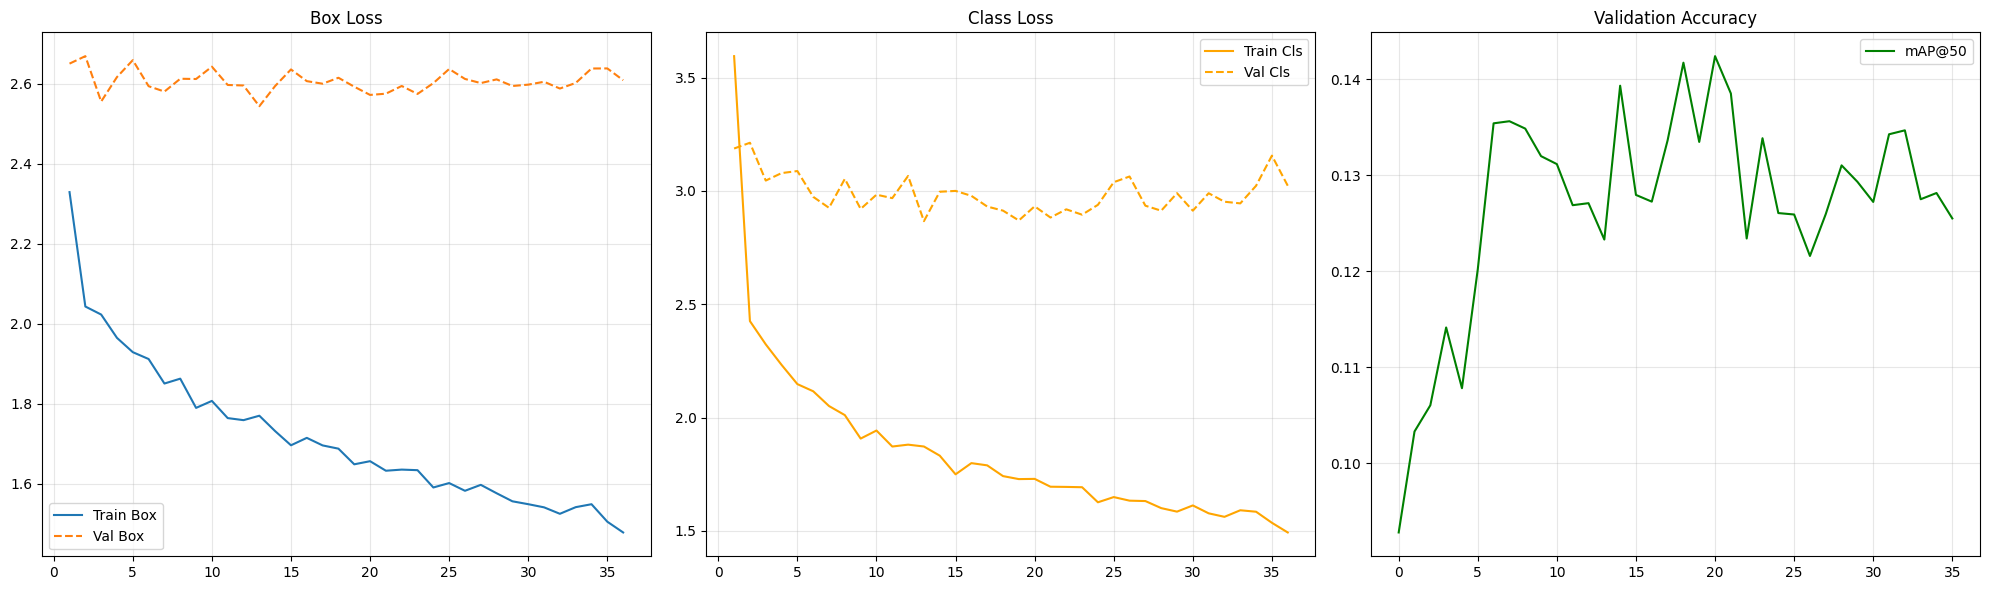

In [8]:
import yaml
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd

# --- CONFIGURATION ---
pipeline_dir = Path("/kaggle/working/stac_pipeline")
weights_path = pipeline_dir / "student_runs/student_final/weights/best.pt"

# Identify the correct YAML file
yaml_path = pipeline_dir / "dental_student.yaml"
if not yaml_path.exists():
    yaml_path = pipeline_dir / "student.yaml"

print(f"Targeting YAML: {yaml_path}")

# ==========================================
# STEP 1: FIX THE YAML FILE (Add 'test' key)
# ==========================================
# 1. Read existing YAML
with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)

# 2. Check if 'test' is missing or broken
# The test data is in the enhanced dataset folder
test_images_path = "/kaggle/working/ssl_dataset_enhanced/test/images"

print(f"Checking test path: {test_images_path}")
if "test" not in data or data["test"] is None:
    print("⚠️ 'test' key was missing. Adding it now...")
    data["test"] = test_images_path
    
    # Write back to file
    with open(yaml_path, 'w') as f:
        yaml.dump(data, f, sort_keys=False)
    print("✅ YAML file updated successfully.")
else:
    print(f"ℹ️ 'test' key exists: {data['test']}")

# ==========================================
# STEP 2: RUN EVALUATION
# ==========================================
if weights_path.exists():
    print(f"\nLoading Model: {weights_path}")
    model = YOLO(weights_path)

    print("--- Running Evaluation on Test Set ---")
    metrics = model.val(
        data=str(yaml_path),
        split='test',        
        imgsz=1024,
        batch=4,
        device=0,
        plots=True
    )

    # Print Metrics
    print("\n" + "="*40)
    print("FINAL EVALUATION METRICS (TEST SET)")
    print("="*40)
    print(f"Precision:    {metrics.box.mp:.4f}")
    print(f"Recall:       {metrics.box.mr:.4f}")
    print(f"mAP@50:       {metrics.box.map50:.4f}")
    print(f"mAP@50-95:    {metrics.box.map:.4f}")
    print("="*40 + "\n")
    
    # ==========================================
    # STEP 3: PLOT CURVES
    # ==========================================
    results_csv_path = pipeline_dir / "student_runs/student_final/results.csv"
    
    if results_csv_path.exists():
        print("--- Plotting Loss Curves ---")
        df = pd.read_csv(results_csv_path)
        df.columns = [c.strip() for c in df.columns]
        
        plt.figure(figsize=(20, 6))
        
        # Box Loss
        plt.subplot(1, 3, 1)
        plt.plot(df['epoch'], df['train/box_loss'], label='Train Box')
        if 'val/box_loss' in df.columns:
            plt.plot(df['epoch'], df['val/box_loss'], label='Val Box', linestyle='--')
        plt.title("Box Loss")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Class Loss
        plt.subplot(1, 3, 2)
        plt.plot(df['epoch'], df['train/cls_loss'], label='Train Cls', color='orange')
        if 'val/cls_loss' in df.columns:
            plt.plot(df['epoch'], df['val/cls_loss'], label='Val Cls', color='orange', linestyle='--')
        plt.title("Class Loss")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Accuracy
        plt.subplot(1, 3, 3)
        plt.plot(df['metrics/mAP50(B)'], label='mAP@50', color='green')
        plt.title("Validation Accuracy")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Warning: results.csv not found.")

else:
    print(f"❌ Error: Model weights not found at {weights_path}")